In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import math
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('/Users/corentinlequeux-peltier/Desktop/HSCO2.csv')
df.head()

,Userd ID,Sub Type,Tenure,1,2,3,4,5,6,7,8,9,10,11,12,Churn
0,2928,Yearly,6,5,4,0,0,2,0,0,3,5,4,1,0,0
1,2934,Monthly,5,34,125,0,58,8,5,2,8,33,2,89,50,0
2,2937,Monthly,5,34,131,0,14,33,31,22,23,28,13,7,1,0
3,2938,Yearly,5,25,31,0,1,3,0,3,2,25,21,0,0,0
4,2939,Yearly,5,18,76,0,20,13,12,17,9,14,11,13,1,0


We're going to create a healthscore based on the correlations between each feature and the Churn. We have two main objectives, considering that if one of those is not reached, the score is not satisfying :

   - Getting a consistent distribution : We want to segment our customer base upon 3 or 4 different categories, we         need thoses categories balanced.
   - Having two clearly different distributions, one for the churners and the other for the non-churners, otherwise our score is useless.

## Finding the correlation coefficients

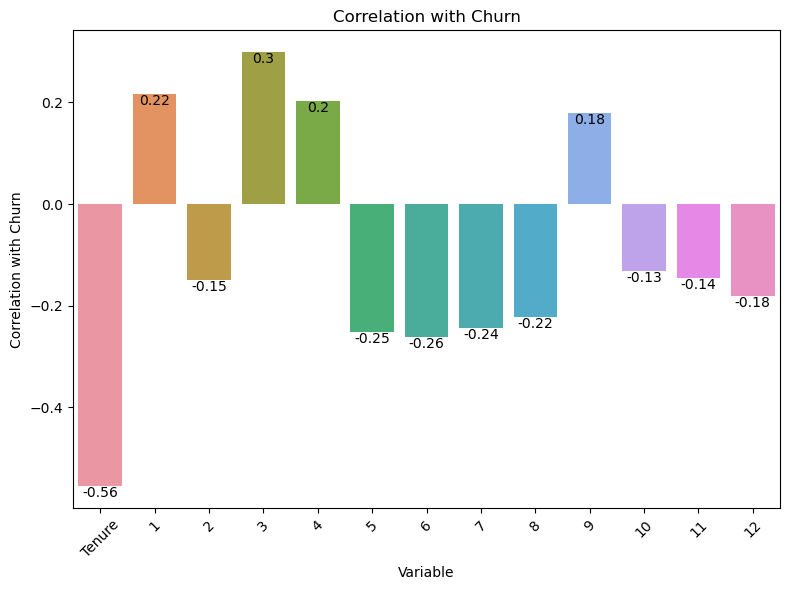

In [3]:
correlations = df.corr()['Churn'].drop(['Churn','Userd ID'])

plt.figure(figsize=(8, 6))
sns.barplot(x=correlations.index, y=correlations.values)
plt.xticks(rotation=45)
plt.xlabel('Variable')
plt.ylabel('Correlation with Churn')
plt.title('Correlation with Churn')
plt.tight_layout()

for i, val in enumerate(correlations.values):
    plt.text(i, val, round(val, 2), ha='center', va='top')
    
plt.show()

In [4]:
# We stock the coefficients in a dictionnary
corr_dict = df.corr()['Churn'].drop(['Churn', 'Userd ID']).to_dict()
corr_dict

{'Tenure': -0.5555822232240433,
 '1': 0.21724607417983535,
 '2': -0.14924546347080167,
 '3': 0.2990180006385608,
 '4': 0.2028437520927414,
 '5': -0.2512246354598749,
 '6': -0.26258865652777164,
 '7': -0.24321473329625262,
 '8': -0.22156227970002873,
 '9': 0.17835559684022761,
 '10': -0.13229671908161242,
 '11': -0.1449300748666917,
 '12': -0.181389769313131}

We're now trying to find the best mathematical expression for the healthscore, starting from the simplest one onto the most complex. 

We'll probably need to use non linear transforms for the following reasons :

- Sensitivity to Minor Changes: Log transforms capture diminishing marginal effects more sensitively.

- Scale Normalization: They compress the scale, making data more manageable and potentially stabilizing variance.

- Non-linear Relationships: Capture complexity in non-linear relationships between variables.

- Outlier Impact: Reduce the influence of extreme values or outliers.

$$
S_1 = \sum{a_i F_i}
$$

In [5]:
def calculate_health_score(row):
    return sum(row[col] * corr_dict[col] for col in corr_dict.keys())

df['Score 1'] = df.apply(calculate_health_score, axis=1)

$$
S_2=\sum{F_i^{a_i}}
$$

In [6]:
def calculate_health_score2(row):
    return sum(row[col] ** corr_dict[col] if not (corr_dict[col] < 0 and row[col] == 0) else 0 for col in corr_dict.keys())

df['Score 2'] = df.apply(calculate_health_score2, axis=1)

$$
S_3=\sum{a_i*log(1 + F_i)}
$$

In [7]:
def calculate_health_score3(row):
    return sum(corr_dict[col] * math.log(1 + row[col]) for col in corr_dict.keys())

df['Score 3'] = df.apply(calculate_health_score3, axis=1)

$$
S_4 = \sum_{i} a_i \left( \frac{1}{F_i + 10^{-10}} \right)
$$

In [8]:
def calculate_score_4(row):
    return sum(corr_dict[col] * (1 / (row[col] + 1e-10)) for col in corr_dict.keys())

df['Score 4'] = df.apply(calculate_score_4, axis=1)

$$
S_5 = \sum_{i} a_i \left( \frac{1}{1 + e^{-F_i}} \right)
$$

In [9]:
def calculate_score_5(row):
    return sum(corr_dict[col] * (1 / (1 + np.exp(-row[col]))) for col in corr_dict.keys())

df['Score 5'] = df.apply(calculate_score_5, axis=1)

$$
S_6= \sum_{i} a_i \tanh(F_i)
$$

In [10]:
def calculate_score_6(row):
    return sum(corr_dict[col] * np.tanh(row[col]) for col in corr_dict.keys())

df['Score 6'] = df.apply(calculate_score_6, axis=1)

In [11]:
df.head()

,Userd ID,Sub Type,Tenure,1,2,3,4,5,6,7,...,10,11,12,Churn,Score 1,Score 2,Score 3,Score 4,Score 5,Score 6
0,2928,Yearly,6,5,4,0,0,2,0,0,...,4,1,0,0,-3.793720,7.390274,-1.509022,-1.853314e+09,-1.068683,-1.014395
1,2934,Monthly,5,34,125,0,58,8,5,2,...,2,89,50,0,-24.211082,11.841267,-2.776035,2.990180e+09,-1.343684,-1.530007
2,2937,Monthly,5,34,131,0,14,33,31,22,...,13,7,1,0,-36.902007,10.821685,-3.840882,2.990180e+09,-1.341446,-1.500294
3,2938,Yearly,5,25,31,0,1,3,0,3,...,21,0,0,0,-2.016309,8.846227,-1.420990,-2.898905e+09,-1.100600,-0.992574
4,2939,Yearly,5,18,76,0,20,13,12,17,...,11,13,1,0,-19.722723,10.823892,-3.290160,2.990180e+09,-1.341547,-1.500294


Let's plot the 6 scores we build, we're separating the churners and non-churners to see if the distributions look significantly different.

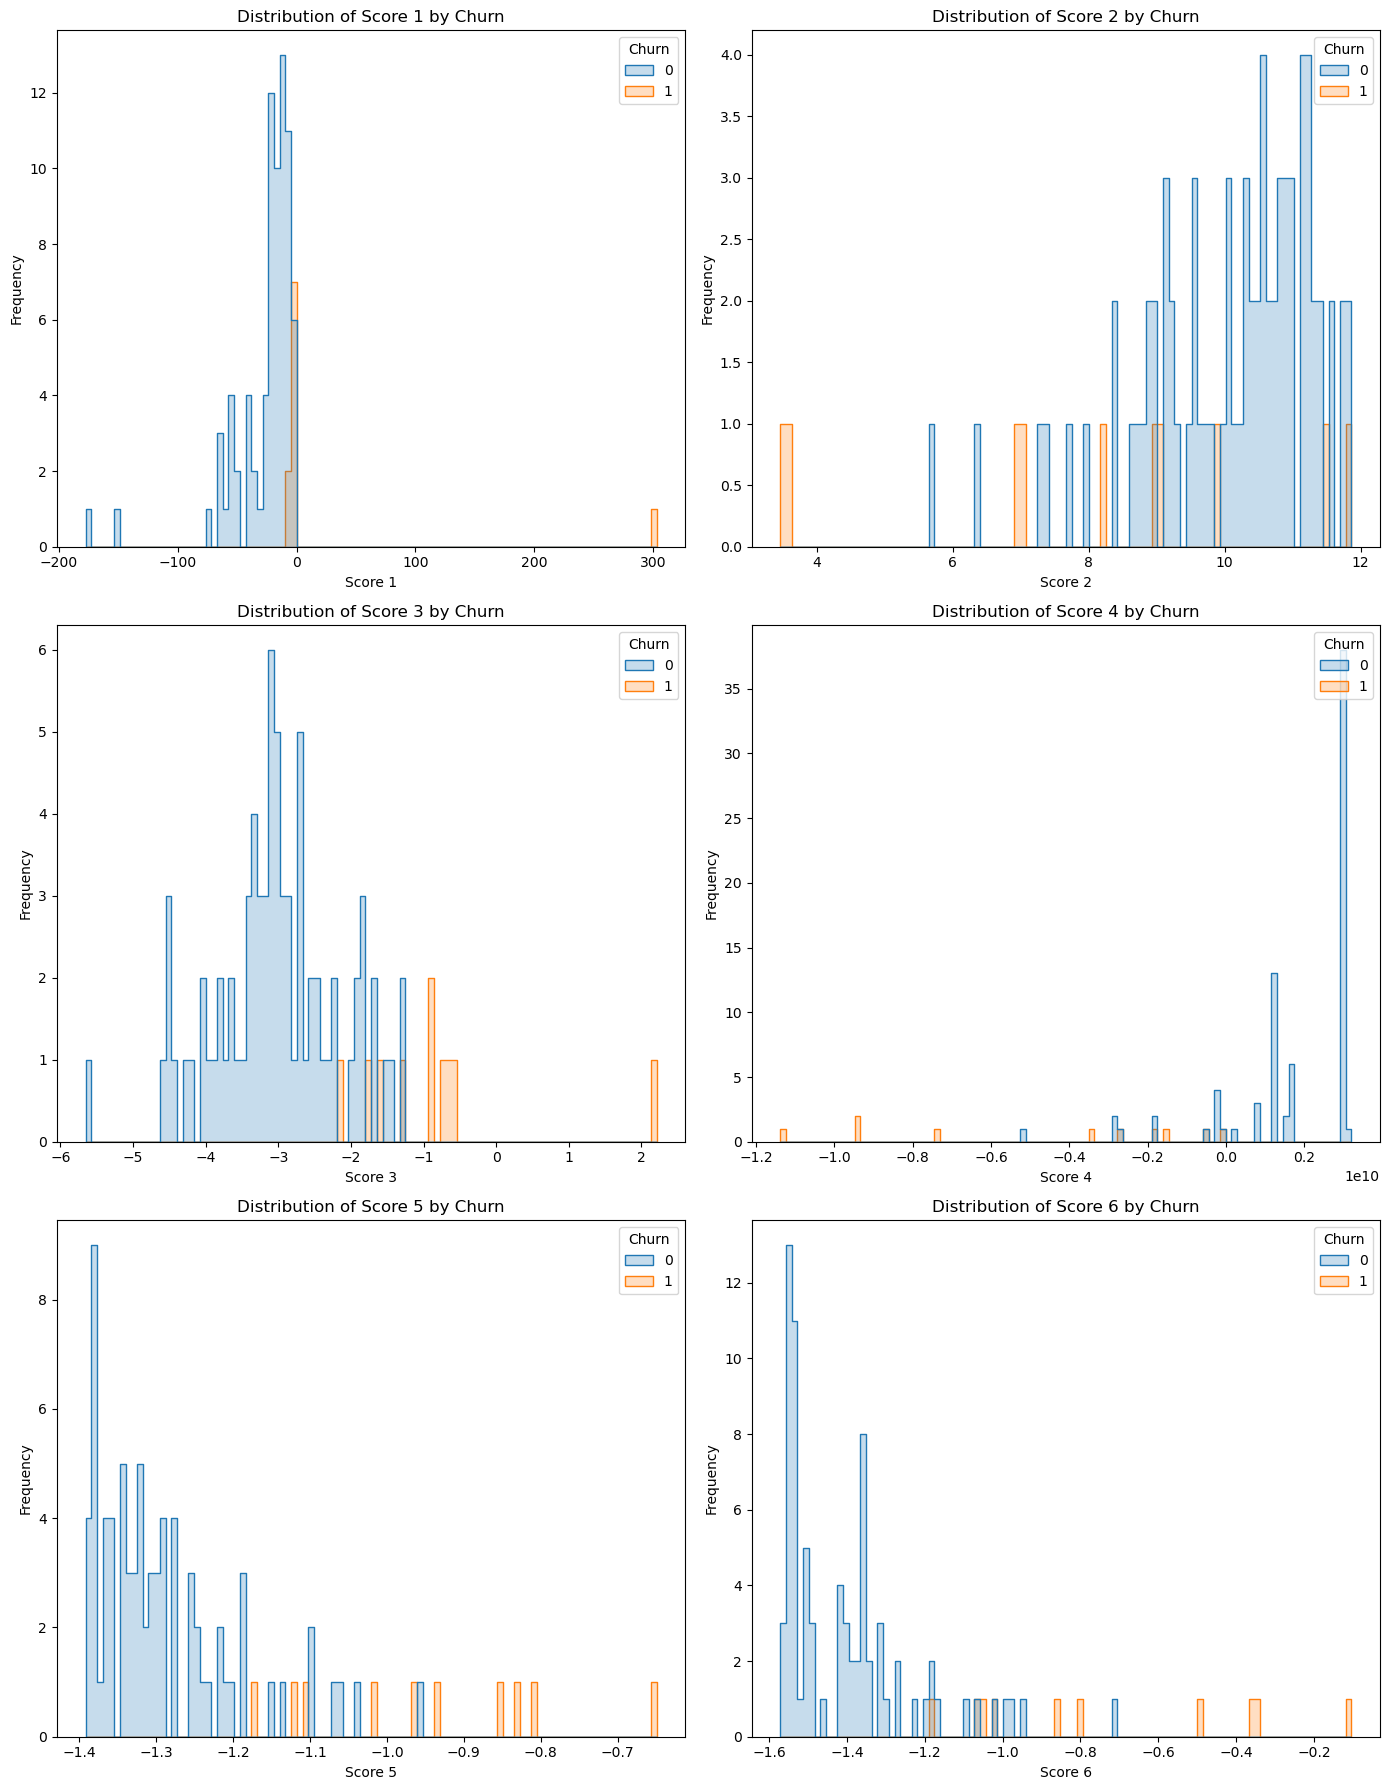

In [12]:
def plot_histograms(df):
    scores = ['Score 1', 'Score 2', 'Score 3', 'Score 4', 'Score 5', 'Score 6']
    
    fig, axes = plt.subplots(3, 2, figsize=(14, 18))  # 3 lignes, 2 colonnes
    axes = axes.flatten()  # Aplatir la grille pour faciliter l'itération
    
    for i, score in enumerate(scores):
        ax = axes[i]
        sns.histplot(data=df, x=score, hue='Churn', element='step', bins=100, ax=ax)
        ax.set_title(f'Distribution of {score} by Churn')
        ax.set_xlabel(score)
        ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

plot_histograms(df)

1. $Log$ => Non-linear transformation, captures complex relationships better than a purely linear expression.
  
2. $Log(1 + F_i)$ => More sensitive to small values of $F_i$ than $F_i$ itself, and avoids $Log(0)$ = always defined.

3. 7.89\% of non-churners are among the churners, 80\% of churners are among the churners, good figures.


In [13]:
churners_data = df[df['Churn'] == 1]
churners_score_3 = churners_data['Score 3']
churners_score_3

76   -1.266678
77   -0.868289
78   -0.654790
79   -0.895555
80   -1.612983
81   -0.585608
82   -0.723414
83   -1.722911
84   -2.114818
85    2.212147
Name: Score 3, dtype: float64

In [14]:
non_churners_data = df[df['Churn'] == 0]

total_non_churners = len(non_churners_data)
non_churners_above_threshold = non_churners_data[non_churners_data['Score 3'] > -1.722911]

count_above_threshold = len(non_churners_above_threshold)
percentage_above_threshold = (count_above_threshold / total_non_churners) * 100

count_above_threshold, percentage_above_threshold
print(f"There are {count_above_threshold} non-churners with 'Score 3' greater than -1.722911, which represents {percentage_above_threshold:.2f}% of all the non-churners.")

There are 6 non-churners with 'Score 3' greater than -1.722911, which represents 7.89% of all the non-churners.


In [15]:
churners_data = df[df['Churn'] == 1]
total_churners = len(churners_data)


churners_above_threshold = churners_data[churners_data['Score 3'] > -1.722911]
count_churners_above_threshold = len(churners_above_threshold)

percentage_churners_above_threshold = (count_churners_above_threshold / total_churners) * 100
print(f"There are {count_churners_above_threshold} churners with a 'Score 3' greater than -1.722911, which represents {percentage_churners_above_threshold:.2f}% of all the churners.")

There are 8 churners with a 'Score 3' greater than -1.722911, which represents 80.00% of all the churners.


In [16]:
non_churners_above_threshold = df[(df['Churn'] == 0) & (df['Score 3'] > -2.114818)].shape[0]
total_non_churners = df[df['Churn'] == 0].shape[0]
prop_non_churners = (non_churners_above_threshold / total_non_churners) * 100


churners_above_threshold = df[(df['Churn'] == 1) & (df['Score 3'] > -2.114818)].shape[0]
total_churners = df[df['Churn'] == 1].shape[0]
prop_churners = (churners_above_threshold / total_churners) * 100


print(f"Among non-churners, {non_churners_above_threshold} have a score greater than -2.114818, which represents {prop_non_churners:.2f}% of all the non-churners.")
print(f"Among churners, {churners_above_threshold} have a score greater than -2.114818, which represents {prop_churners:.2f}% of all the churners.")

Among non-churners, 12 have a score greater than -2.114818, which represents 15.79% of all the non-churners.
Among churners, 10 have a score greater than -2.114818, which represents 100.00% of all the churners.


100% of churners are identified for only 15.79% of false positives.
We want to scale this score to make easily understandable by everyone.

In [17]:
min_score = df['Score 3'].min()
max_score = df['Score 3'].max()

df['Score_3_scaled'] = ((df['Score 3'] - min_score) / (max_score - min_score)) * 10
churners_data = df[df['Churn'] == 1]
churners_score_scaled_3 = churners_data['Score_3_scaled']
churners_score_scaled_3

76     5.577179
77     6.083674
78     6.355107
79     6.049009
80     5.136903
81     6.443061
82     6.267861
83     4.997146
84     4.498893
85    10.000000
Name: Score_3_scaled, dtype: float64

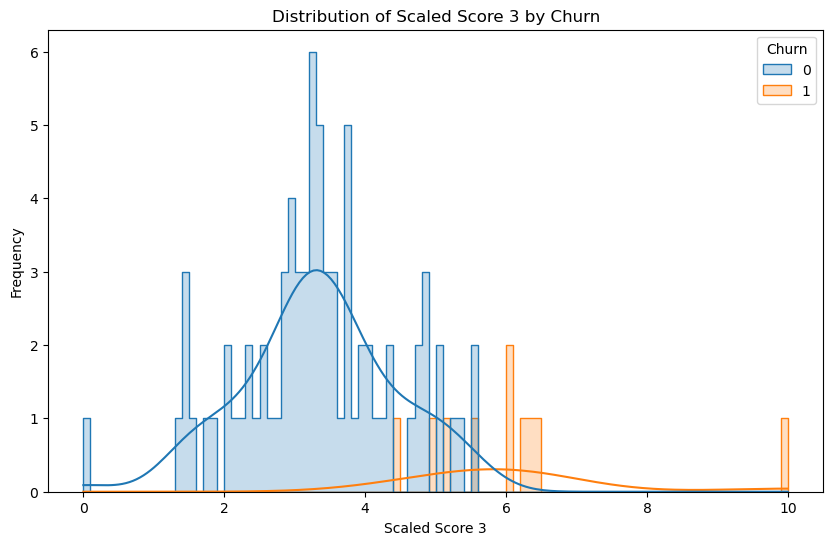

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(df, x='Score_3_scaled', bins=100, kde=True, hue='Churn', element='step', stat='count')
plt.title('Distribution of Scaled Score 3 by Churn')
plt.xlabel('Scaled Score 3')
plt.ylabel('Frequency')
plt.show()

We can viusally identify four different categories :

In [19]:
bins = [0, 2, 4, 6, float('inf')]
labels = ['<2','2-4', '4-6', '>6']

df['Score_3_scaled_category'] = pd.cut(df['Score_3_scaled'], bins=bins, labels=labels, right=False)

count_by_category = df['Score_3_scaled_category'].value_counts().sort_index()
total_users = len(df)
percentage_by_category = (count_by_category / total_users) * 100

summary_df = pd.DataFrame({
    'Count': count_by_category,
    'Percentage': percentage_by_category 
}).reset_index().rename(columns={'index': 'Score_3_scaled_category'})

print(summary_df)

  Score_3_scaled_category  Count  Percentage
0                      <2      8    9.302326
1                     2-4     50   58.139535
2                     4-6     22   25.581395
3                      >6      6    6.976744


The users below 2 are "Top Users"
The users between 2 and 4 are "OK"
The users between 4 and 6 are "At risk"
The users above 6 are "Dangerous"

### Conclusion

Of course in the situation we should keep going with a generalization to every users of the product.
The objective here was only to showcase how great things can be achieved without necessary using machine learning or advanced techniques.